In [61]:
import pandas as pd

In [99]:
#df = pd.read_excel('GFR-SVR数据.xls', converters={'编号':int, '年龄':int, '性别':int, 'rGFR':float, 'Scr':float, 'Cys':float})
df = pd.read_excel('GFR-SVR数据.xls')

In [100]:
df.head()

,编号,年龄,性别,rGFR,Scr,Cys
0,85,34,1,76.67,1.161765,1.14
1,86,60,2,15.07,1.432127,2
2,618,47,2,148.20,0.497681,0.98
3,617,47,2,142.20,0.251103,0.64
4,598,45,2,138.00,0.721638,0.72


In [101]:
df.shape

(1197, 6)

In [102]:
df.dtypes

编号        int64
年龄        int64
性别        int64
rGFR    float64
Scr     float64
Cys      object
dtype: object

In [103]:
df.columns = ['id', 'age', 'sex', 'rGFR', 'Scr', 'Cys']
df.head()
# 1指男性 2指女性, xls里写了，DataFrame丢掉了这些元信息。

df['Cys'] = pd.to_numeric(df['Cys'], errors='coerce')
df.dtypes

id        int64
age       int64
sex       int64
rGFR    float64
Scr     float64
Cys     float64
dtype: object

In [104]:
np.where(pd.isna(df['Cys']))

(array([ 341,  495,  675,  845,  848,  929,  940, 1001, 1060], dtype=int64),)

In [105]:
df=df.dropna()
df.shape

(1188, 6)

看样子问题是使用自变量，年龄，性别，rGFR,Scr去回归（指定用SVR，支持向量回归）去回归因变量Cys。

这个问题需要与用经验公式的结果比较，估计是以前用其他方法回归出来的。比如在性别为女，$Cr \le 0.7$(Cr就是Scr)时使用公式
$$
rGFR = 144\times(Scr/0.7)^{-0.329}\times0.993^{age}
$$
计算。这样的分段经验公式很多。

SVR（Support vector regression）其实就是把普通回归的loss改了一下，现在不是算平方损失而是算一种对小损失当成没损失的的loss。另外就是
加上了kernel。或者说它就是SVM用到回归上的结果。recall SVM其实就是训练出出一些向量，每个类型对应一个向量，新数据与向量直接做内积
或以某个核函数做内积（有时候等价于变换数据后做线性的直接内积，不过不是所有核函数都可以这么表示，比如径向基函数好像就不行，它们的那个
数据的变换是无穷维的）。内积算的就是相似度，然后可以怎么拿这个相似度来预测类别了。

支持向量机的训练比预测有意思些，它们的目标当然是出来的向量经过上述过程分离效果最好。SVM用一种小损失不算损失的loss来优化。可能是因为
这种loss的解是可以解析得到的。

基本回归里哪里有内积呢，当然就是权重$w$了。支持向量回归使得我们可以把这个内积形式改掉，也就是权重如何与数据的属性结合的方式变化了。


看错了，貌似Cys也是自变量。rGFR才是因变量。

In [106]:
def CKD_EPI_Cr(r):
    '''
    Usage:
        df.apply(CKD_EPI_Cr, axis=1)
    '''
    sex, Scr, age = r['sex'],r['Scr'],r['age']
    if sex == 2:
        if Scr <= 0.7:
            return 144*(Scr/0.7)**(-0.329) * 0.993**age
        else:
            return 144*(Scr/0.7)**(-1.209) * 0.993**age
    else:
        if Scr <= 0.9:
            return 141*(Scr/0.9)**(-0.411) * 0.993**age
        else:
            return 141*(Scr/0.9)**(-1.209) * 0.993**age
        
def CKD_EPI_Cys(r):
    sex, Cys, age = r['sex'],r['Cys'],r['age']
    if sex == 2:
        if Cys <= 0.8:
            return 133*(Cys/0.8)**(-0.499) * 0.996**age * 0.932
        else:
            return 133*(Cys/0.8)**(-1.328) * 0.996**age * 0.932
    else:
        if Cys <= 0.8:
            return  133*(Cys/0.8)**(-0.499) * 0.996**age
        else:
            return  133*(Cys/0.8)**(-1.328) * 0.996**age
        
def CKD_EPI_Cr_Cys(r):
    sex, Scr, Cys, age = r['sex'], r['Scr'], r['Cys'],r['age']
    if sex ==2:
        if Scr <= 0.7:
            if Cys <= 0.8:
                return 130*(Scr/0.7)**(-0.248) * (Cys/0.8)**(-0.375) * 0.995**age
            else:
                return 130*(Scr/0.7)**(-0.248) * (Cys/0.8)**(-0.711) * 0.995**age
        else:
            if Cys <= 0.8:
                return 130*(Scr/0.7)**(-0.601) * (Cys/0.8)**(-0.375) * 0.995**age
            else:
                return 130*(Scr/0.7)**(-0.601) * (Cys/0.8)**(-0.711) * 0.995**age
    else:
        if Scr <= 0.9:
            if Cys <= 0.8:
                return 135*(Scr/0.9)**(-0.207) * (Cys/0.8)**(-0.375) * 0.995**age
            else:
                return 135*(Scr/0.9)**(-0.207) * (Cys/0.8)**(-0.711) * 0.995**age
        else:
            if Cys <= 0.8:
                return 135*(Scr/0.9)**(-0.601) * (Cys/0.8)**(-0.375) * 0.995**age
            else:
                return 135*(Scr/0.9)**(-0.601) * (Cys/0.8)**(-0.711) * 0.995**age
            
def FAS_cr(r):
    sex, Scr, age = r['sex'],r['Scr'],r['age']
    O_Cr = 0.7 if r['sex'] == 2 else 0.9
    t = 1. if age <= 40 else 0.988**(age-40)
    return 107.3/(Scr/O_Cr) * t

def FAS_Cys(r):
    sex, Cys, age = r['sex'],r['Cys'],r['age']
    O_Cys = 0.82 if r['age'] <= 70 else 0.95
    t = 1.0 if age <= 40 else 0.988*(age-40)
    return 107.3/(Cys/O_Cys) * t

def FAS_Cr_Cys(r):
    sex, Scr, Cys, age = r['sex'],r['Scr'],r['Cys'],r['age']
    O_Cr = 0.7 if r['sex'] == 2 else 0.9
    O_Cys = 0.82 if r['age'] <= 70 else 0.95
    t = 1.0 if age <= 40 else 0.988*(age-40)
    return 107.3/(0.5*(Scr/O_Cr)+0.5*(Cys/O_Cys)) * t

In [107]:
df.apply(CKD_EPI_Cr,axis=1).head()

0     81.553927
1     39.761190
2    115.802372
3    145.031806
4    101.179886
dtype: float64

In [108]:
d = df.loc[0]
141*(d['Scr']/0.9)**(-1.209)*0.993**d['age']

81.55392688601036

In [109]:
df.apply(CKD_EPI_Cys, axis=1)


0        72.510852
1        28.864466
2        78.417273
3       114.766346
4       109.086440
5        85.845036
6       111.812885
7        78.640928
8       110.797262
9       102.872123
10      125.667599
11      133.124615
12      117.374872
13      114.936957
14      116.054405
15       99.785856
16      124.820569
17      117.859136
18       95.605970
19       88.465798
20      142.985697
21      119.939389
22       69.879469
23       77.367119
24      125.279314
25       94.165884
26      117.861708
27      123.941358
28       63.673607
29      130.402519
           ...    
1167     12.146489
1168      6.218845
1169      8.645172
1170     12.165492
1171     10.568800
1172      8.800091
1173      7.356331
1174     14.152652
1175     16.322026
1176      7.393447
1177      8.568864
1178      8.523443
1179      6.860223
1180     13.206399
1181      9.804507
1182     11.281034
1183     10.348673
1184     25.547659
1185      7.859126
1186      9.512708
1187      9.049249
1188      7.

In [110]:

df['CKD_EPI_Cr'] = df.apply(CKD_EPI_Cr, axis=1)
df['CKD_EPI_Cys'] = df.apply(CKD_EPI_Cys, axis=1)
df['CKD_EPI_Cr_Cys'] = df.apply(CKD_EPI_Cr_Cys, axis=1)
df['FAS_cr'] = df.apply(FAS_cr, axis=1)
df['FAS_Cys'] = df.apply(FAS_Cys, axis=1)
df['FAS_Cr_Cys'] = df.apply(FAS_Cr_Cys, axis=1)

In [111]:
df

,id,age,sex,rGFR,Scr,Cys,CKD_EPI_Cr,CKD_EPI_Cys,CKD_EPI_Cr_Cys,FAS_cr,FAS_Cys,FAS_Cr_Cys
0,85,34,1,76.670000,1.161765,1.14,81.553927,72.510852,75.913649,83.123544,77.180702,80.041966
1,86,60,2,15.070000,1.432127,2.00,39.761190,28.864466,32.625106,41.196016,869.301680,945.500992
2,618,47,2,148.200000,0.497681,0.98,115.802372,78.417273,96.761765,138.689981,620.929771,778.646113
3,617,47,2,142.200000,0.251103,0.64,145.031806,114.766346,144.009295,274.881043,950.798713,1302.813935
4,598,45,2,138.000000,0.721638,0.72,101.179886,109.086440,105.972962,97.985812,603.681722,555.341141
5,835,32,1,137.800000,0.952381,1.01,105.170060,85.845036,94.174073,101.398500,87.114851,93.715540
6,974,53,1,137.700000,0.591562,0.74,115.459808,111.812885,116.246005,139.534697,1527.151600,1767.178987
7,887,41,1,137.300000,0.653772,1.05,120.556797,78.640928,96.793544,145.939458,82.790636,105.647843
8,530,28,2,137.100000,0.451306,0.80,136.665086,110.797262,125.969381,166.427947,109.982500,132.441895
9,901,44,1,136.400000,0.620970,0.85,120.566750,102.872123,111.993278,148.183230,409.083144,491.209603


FAS公式在很多情况下都偏的离谱怎么理解。。确实按它那个公式如果它使用的那个数比较小的话数值就会爆炸。估计要大于1还能谈谈。

In [ ]:
df.

In [120]:
(df[index_list].apply(lambda col:col-df['rGFR'],axis=0)**2).mean(axis=0) #均方误差

CKD_EPI_Cr        3.751869e+02
CKD_EPI_Cys       4.130177e+02
CKD_EPI_Cr_Cys    3.246929e+02
FAS_cr            6.550004e+02
FAS_Cys           1.699370e+06
FAS_Cr_Cys        1.946557e+06
dtype: float64

就算要用SVR回归，大致上应该还是要遵循这个指数的规律，也就是数据应当做类似这里的变换，而钦定的值换成自由参数效果肯定会更好。

输这些公式也太麻烦了，看看能不能反向出这些数是怎么拟合出来的。
$$
\log rGFR = \log 144\times(Scr/0.7)^{-0.329}\times0.993^{age} \\
\log rGFR = \log 144 -0.329 \log(Scr/0.7) + 0.993 age
$$

141，144之类的数应该是钦定的，估计是什么通过均值之类的指标直接定出来的。系数是调整“曲率”之类的。

In [42]:
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [47]:
df['log_Scr_d07'] = np.log(df['Scr']/0.7)
df['log_rGFR'] = np.log(df['rGFR'])
df['log_rGFR_n144'] = df['log_rGFR'] - np.log(144)
df['log_rGFR_n141'] = df['log_rGFR'] - np.log(141)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


(array([  4.,  69., 322., 370., 157., 100.,  79.,  57.,  31.,   8.]),
 array([-1.02521785, -0.60888281, -0.19254776,  0.22378728,  0.64012233,
         1.05645737,  1.47279241,  1.88912746,  2.3054625 ,  2.72179755,
         3.13813259]),
 <a list of 10 Patch objects>)

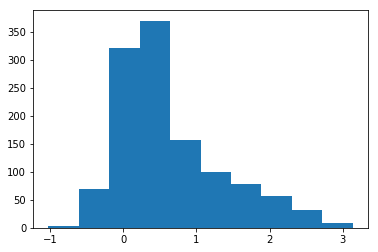

In [43]:
plt.hist(df['log_Scr_d07'])

(array([ 56., 140., 144., 166., 197., 217., 146.,  91.,  31.,   9.]),
 array([  0.  ,  14.82,  29.64,  44.46,  59.28,  74.1 ,  88.92, 103.74,
        118.56, 133.38, 148.2 ]),
 <a list of 10 Patch objects>)

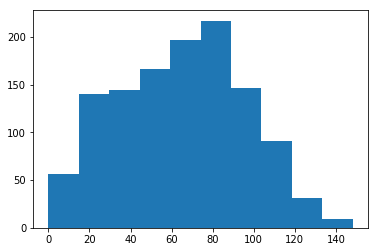

In [45]:
plt.hist(df['rGFR'])

In [51]:
smf.ols('log_rGFR_n144 ~ log_Scr_d07 + age -1', data=df[(df['sex'] == 2) & (df['Scr'] <= 0.7)]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rGFR_n144   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     369.4
Date:                Thu, 28 Feb 2019   Prob (F-statistic):           1.59e-51
Time:                        12:21:13   Log-Likelihood:                 44.416
No. Observations:                 120   AIC:                            -84.83
Df Residuals:                     118   BIC:                            -79.26
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
log_Scr_d07    -0.0481      0.074     -0.651      0.516      -0.194       0.098
age            -0.0090      0.000    -21.361      0.000      -0.010      -0.008
==============================================================================
Omnibus:                        0.774   Durbin-Watson:                   0.848
Prob(Omnibus):                  0.679   Jarque-Bera (JB):                0.372
Skew:                          -0.046   Prob(JB):                        0.830
Kurtosis:                       3.256   Cond. No.                         227.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
dfp = df.loc[:df.shape[0]-1] # last record is hard to deal

In [133]:
yp = np.log(dfp['rGFR'])
Xp = dfp[]

(1188, 12)